In [ ]:
Fashion MNIST CLassification Using CNN

In [23]:
!pip install opendatasets

In [24]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/zalando-research/fashionmnist")

Skipping, found downloaded files in "./fashionmnist" (use force=True to force download)


In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


In [26]:
torch.manual_seed(42)

In [27]:
df=pd.read_csv("/content/fashionmnist/fashion-mnist_train.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
df.shape

(60000, 785)

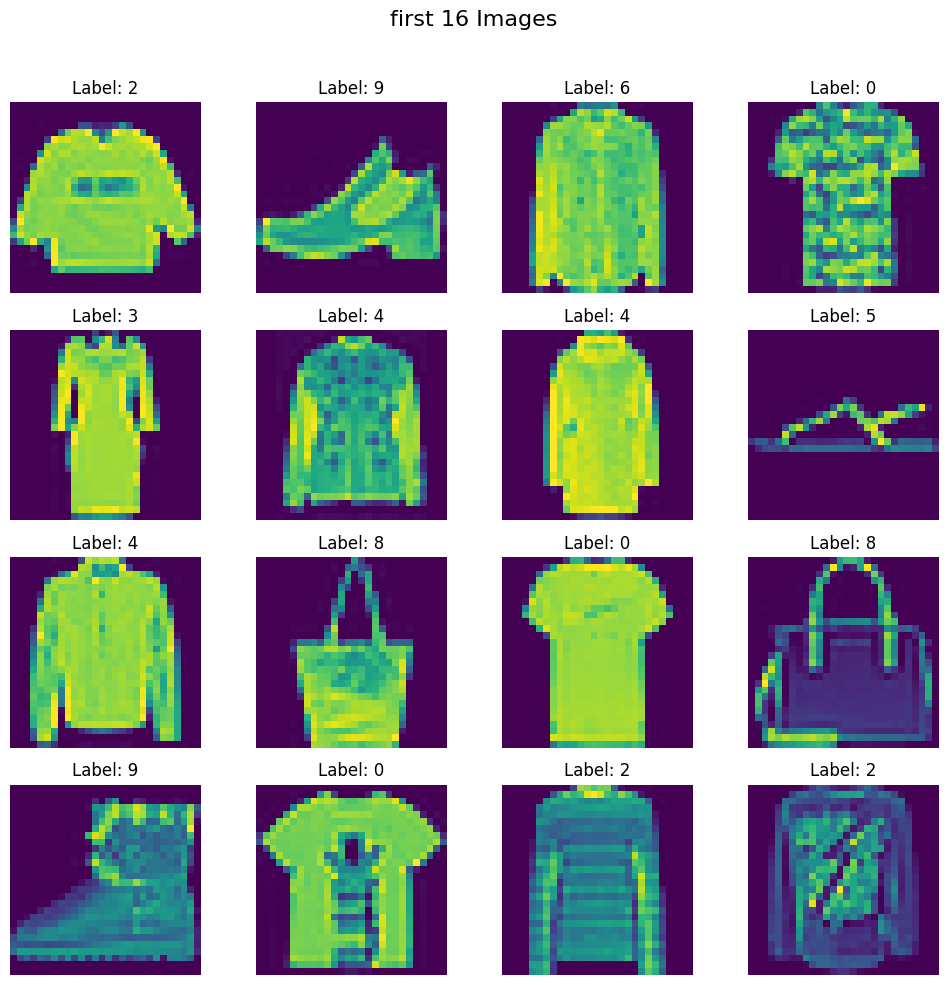

In [29]:
#creating 4x4 grid of image
fig, axes =plt.subplots(nrows=4,ncols=4,figsize=(10,10))
fig.suptitle("first 16 Images",fontsize=16)

#plotting the first 16 image from the dataset
for i,ax in enumerate(axes.flat):
  img=df.iloc[i,1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(f"Label: {df.iloc[i,0]}")
plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [30]:
#train test split
X=df.iloc[:,1:].values
y=df.iloc[:,0].values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [31]:
X_train=X_train/255.0
X_test=X_test/255.0

In [32]:
class CustomDataset(Dataset):
  def __init__(self,features,labels):
    #converting to pytorch tensor
    self.features=torch.tensor(features,dtype=torch.float32).reshape(-1,1,28,28)
    self.labels=torch.tensor(labels,dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self,index):
    return self.features[index],self.labels[index]

In [33]:
train_dataset=CustomDataset(X_train,y_train)
test_dataset=CustomDataset(X_test,y_test)

In [34]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True,pin_memory=True)
test_loader=DataLoader(test_dataset,batch_size=64,shuffle=False,pin_memory=True)


In [35]:
#Architecture
class MyNN(nn.Module):
  def __init__(self,input_features):
    super().__init__()

    self.features=nn.Sequential(
        nn.Conv2d(input_features,32,kernel_size=3,padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2,stride=2),

        nn.Conv2d(32,64,kernel_size=3,padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2,stride=2),
    )
    self.classifier=nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*7*7,128),
        nn.ReLU(),
        nn.Dropout(p=0.4),

        nn.Linear(128,64),
        nn.ReLU(),
        nn.Dropout(p=0.4),
        nn.Linear(64,10)
    )

  def forward(self,x):
    x=self.features(x)
    x=self.classifier(x)

    return x

In [36]:
learning_rate=0.001
epochs=20

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model=MyNN(1)

model.to(device)

criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-4)

In [38]:
#training Loop

for epoch in range(epochs):
  total_epoch_loss=0

  for batch_features,batch_labels in train_loader:

    batch_features,labels=batch_features.to(device),batch_labels.to(device)
    outputs=model(batch_features)
    loss=criterion(outputs,labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_epoch_loss=total_epoch_loss + loss.item()
  avg_loss=total_epoch_loss/len(train_loader)
  print(f"Epoch: {epoch+1}/{epochs}, Loss: {avg_loss}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1/20, Loss: 1.3431578770875932
Epoch: 2/20, Loss: 0.7721687074303627
Epoch: 3/20, Loss: 0.6367027874588966
Epoch: 4/20, Loss: 0.5623308007419109
Epoch: 5/20, Loss: 0.509992114931345
Epoch: 6/20, Loss: 0.4714170966545741
Epoch: 7/20, Loss: 0.4426303882350524
Epoch: 8/20, Loss: 0.42241219126681484
Epoch: 9/20, Loss: 0.3989549100945393
Epoch: 10/20, Loss: 0.3790289819637934
Epoch: 11/20, Loss: 0.36579874986410144
Epoch: 12/20, Loss: 0.35632435213774444
Epoch: 13/20, Loss: 0.33802450572450954
Epoch: 14/20, Loss: 0.3284776827270786
Epoch: 15/20, Loss: 0.3172583478440841
Epoch: 16/20, Loss: 0.3074791314105193
Epoch: 17/20, Loss: 0.3004172826583187
Epoch: 18/20, Loss: 0.2952008091385166
Epoch: 19/20, Loss: 0.2867215223833919
Epoch: 20/20, Loss: 0.2807834348802765


In [39]:
model.eval()

MyNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [40]:
#evaluation on test data
total=0
correct=0

with torch.no_grad():
  for batch_features,batch_labels in test_loader:
    batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
    outputs=model(batch_features)
    _,predicted=torch.max(outputs,1)
    total+=batch_labels.shape[0]
    correct+=(predicted==batch_labels).sum().item()

print(correct/total)

0.9129166666666667


In [41]:
#evaluation on training data
total=0
correct=0

with torch.no_grad():
  for batch_features,batch_labels in train_loader:
    batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
    outputs=model(batch_features)
    _,predicted=torch.max(outputs,1)
    total+=batch_labels.shape[0]
    correct+=(predicted==batch_labels).sum().item()

print(correct/total)

0.9301458333333333
